# < Meaningful title >

##### Imports

In [1]:
# Google Maps API
import googlemaps

# Basic libraries
import pandas as pd
import numpy as np
import os

# Custom util functions
import sys; sys.path.append("./libraries/")
from utils import *

# Classification models
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistics
from scipy.stats import tukey_hsd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Maps
import folium
from folium.plugins import MarkerCluster

import warnings; warnings.filterwarnings('ignore')

### Settings

##### Reproducibility settings

In [2]:
# Random seed
np.random.seed = 7

# Relative Paths
RAW_DATA = "../data/raw_data/"
PROCESSED_DATA = "../data/processed_data/"
ANNOTATIONS_DATA = "../annotations/"

# Flags
collect = False # Flag to collect data or load existent raw_data
process = False # Flag to process data or load existent processed data

##### Google API

In [3]:
key = open("./Google_API_key.txt").readline()
gmaps = googlemaps.Client(key=key)

# 1. Data Collection

We start by creating a list of query values that relate to the dataset. We are interested in getting mostly reviews (and some other metadata) on specific fitness facilities (i.e. popular chains) from main cities in Denmark. To do this, we will compute the query list as a combination of cities and fitness chains. 

In [4]:
# List of cities
cities = ['Copenhagen', 'Aalborg', 'Arhus', 'Odense']
 
# Popular fitness chains
gyms = ["PureGym", "SATS", "Vesterbronx"]

# Query list
query_list = [g + " " + c for g in gyms for c in cities]

print(query_list)

['PureGym Copenhagen', 'PureGym Aalborg', 'PureGym Arhus', 'PureGym Odense', 'SATS Copenhagen', 'SATS Aalborg', 'SATS Arhus', 'SATS Odense', 'Vesterbronx Copenhagen', 'Vesterbronx Aalborg', 'Vesterbronx Arhus', 'Vesterbronx Odense']


## 1.1 Google Maps API

The Google maps API takes a single query string to search for results (similar to the User Interface searchbox). Therefore, we combine popular fitness facilities with main Danish cities as our query keys.

### 1.1.1 Reviews
We start by getting the reviews for our query list.

Get responses for all the queries from the API

In [5]:
if collect:
    # Get response for queries
    dfs = []

    # For each query in the query list
    for query in query_list:  
        # Get the response using our custom made querier
        dfs.append(google_querier(gmaps, query))

    google_reviews = pd.concat(dfs)

    # Save to disk
    google_reviews.to_csv(RAW_DATA + "google_reviews.csv", index=False, encoding="utf-8")

else:
    google_reviews = pd.read_csv(RAW_DATA + "google_reviews.csv")

Check the results.

In [6]:
check_dataframe_results(google_reviews)

Resulting dataframe has shape (360, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   place_id       360 non-null    object 
 1   type           360 non-null    object 
 2   name           360 non-null    object 
 3   lat            360 non-null    float64
 4   lng            360 non-null    float64
 5   author_name    360 non-null    object 
 6   rating         360 non-null    int64  
 7   text           360 non-null    object 
 8   opening_hours  360 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 25.4+ KB
None


,place_id,type,name,lat,lng,author_name,rating,text,opening_hours
0,ChIJh3mB6UxSUkYREbiH4JDK-7M,PureGym Copenhagen,PureGym,55.669812,12.54739,madi sharp,4,"Sweet small gym, staff are kind when you see t...","{'Monday': '05:00AM - 12:00AM', 'Tuesday': '05..."
1,ChIJh3mB6UxSUkYREbiH4JDK-7M,PureGym Copenhagen,PureGym,55.669812,12.54739,Lewis Atkins,2,"Just a very bad gym. Staff don’t really care, ...","{'Monday': '05:00AM - 12:00AM', 'Tuesday': '05..."
2,ChIJh3mB6UxSUkYREbiH4JDK-7M,PureGym Copenhagen,PureGym,55.669812,12.54739,Eric,1,"terrible facilities\nbathrooms are gross, dirt...","{'Monday': '05:00AM - 12:00AM', 'Tuesday': '05..."
3,ChIJh3mB6UxSUkYREbiH4JDK-7M,PureGym Copenhagen,PureGym,55.669812,12.54739,Rune Perstrup,1,An Unhygienic Coronavirus Petri Dish.\n\nI hav...,"{'Monday': '05:00AM - 12:00AM', 'Tuesday': '05..."
4,ChIJh3mB6UxSUkYREbiH4JDK-7M,PureGym Copenhagen,PureGym,55.669812,12.54739,Mario Piazza,1,In a huge gym there is only one hair dryer and...,"{'Monday': '05:00AM - 12:00AM', 'Tuesday': '05..."


### 1.1.2 Nearby Transportation
We are interested in collecting the nearby transportation to the fitness centers.

In [7]:
if collect:

    # Radius of search in meters
    radius = 500

    # Transportation type key (similar to what one would input in Google Maps search box)
    transportation_type = ['bus_station', 'train_station', 'transit_station'] # Avaliable transportation: only bus station, train station and transit station (which includes metro)

    # Container
    nearby_transportation = []

    # We iterate through all our fitness centers, and retrieve nearby transportations
    for ix, row in google_reviews.iterrows():
        # Extract info from fitness center
        place_id = row.place_id
        location = {"lat": row.lat, "lng": row.lng}
        # Look at nearby transportation
        df = google_nearby(gmaps, place_id = place_id, keys = transportation_type, location = location, radius = radius)
        # Append results
        nearby_transportation.append(df)

    # Join all results
    nearby_transportation = pd.concat(nearby_transportation)

    # Save to disk
    nearby_transportation.to_csv(RAW_DATA + "transportation.csv", index=False, encoding="utf-8")

else:
    nearby_transportation = pd.read_csv(RAW_DATA + "transportation.csv")

Check the results.

In [8]:
check_dataframe_results(nearby_transportation)

Resulting dataframe has shape (6195, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6195 entries, 0 to 6194
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   place_id                6195 non-null   object 
 1   transport_id            6195 non-null   object 
 2   transport_name          6195 non-null   object 
 3   transport_type          6195 non-null   object 
 4   transport_lat           6195 non-null   float64
 5   transport_lng           6195 non-null   float64
 6   distance_gym_transport  6195 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 338.9+ KB
None


,place_id,transport_id,transport_name,transport_type,transport_lat,transport_lng,distance_gym_transport
0,ChIJh3mB6UxSUkYREbiH4JDK-7M,ChIJ-y92w3VTUkYRY8NOJNuwQkQ,Kridt v/Rikke Frisk,bus_station,55.668036,12.551084,305
1,ChIJh3mB6UxSUkYREbiH4JDK-7M,ChIJ76k9hJ9TUkYRRaHYcLRX3XE,Lysholdet v/Jakob Holst,bus_station,55.672786,12.547279,331
2,ChIJh3mB6UxSUkYREbiH4JDK-7M,ChIJydMagp9TUkYRjfgBz2sKErQ,"Ejerforeningen Sigbrits Allé 3, 5 og 5a",bus_station,55.672865,12.546713,343
3,ChIJh3mB6UxSUkYREbiH4JDK-7M,ChIJydMagp9TUkYRcgSv8LkczNs,Grundejerforeningen Carl Jacobsens Vej 33-41,bus_station,55.672865,12.546713,343
4,ChIJh3mB6UxSUkYREbiH4JDK-7M,ChIJl46JnZ5TUkYRnW93t25gFhQ,Optiperform v/Maja Juel-Hansen,bus_station,55.668011,12.542917,346


## 1.2 Trustpilot WebScraper

Trustpilot is a Danish consumer review website very popular in Denmark. It is publicly available and easy to access, but it does not provide any API integration. Therefore, we use a simple webcrawler to extract the reviews of interest.

In [9]:
if collect:
    dfs = []

    # Reuse the gyms
    for g in gyms:
        df = trustpilot_crawler(key=g, verbose=False)

        # Append the facility DF to main df
        dfs.append(df)

    # Join all DFs
    trustpilot_reviews = pd.concat(dfs)

    # Save to disk
    trustpilot_reviews.to_csv(RAW_DATA + "trustpilot_reviews.csv", index=False, encoding="utf-8")

else:
    trustpilot_reviews = pd.read_csv(RAW_DATA + "trustpilot_reviews.csv", encoding="utf-8")

Check the results.

In [10]:
check_dataframe_results(trustpilot_reviews)

Resulting dataframe has shape (2802, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    2802 non-null   object
 1   name        2802 non-null   object
 2   rating      2802 non-null   int64 
 3   title       2802 non-null   object
 4   review      2802 non-null   object
 5   event_time  2802 non-null   object
 6   enterprise  2802 non-null   object
dtypes: int64(1), object(6)
memory usage: 153.4+ KB
None


,datetime,name,rating,title,review,event_time,enterprise
0,2023-11-13T14:03:40.000Z,Jan Winther,4,Godt fitness-center,Gennemgående er jeg godt tilfreds med mit fitn...,13. november 2023,PureGym
1,2023-11-14T13:07:20.000Z,Tina Holst,5,Syntes altid det er dejligt at komme i…,Syntes altid det er dejligt at komme i centret...,14. november 2023,PureGym
2,2023-11-13T09:22:36.000Z,Pfændtner,5,Jeg har gået i Fitness centeret i 22år…,Jeg har gået i Fitness centeret i 22år og efte...,12. november 2023,PureGym
3,2023-11-13T17:18:33.000Z,Gitte,5,Puregym Ikast,Puregym Ikast er et fantastisk center. Man føl...,13. november 2023,PureGym
4,2023-11-13T10:01:35.000Z,GITTE MIKKELSEN,2,Der mangler Stram op hold,Der mangler Stram op hold (eller ligende fx Pu...,11. november 2023,PureGym


## 1.3 Københavns Kommune Scraper

The Københavns Kommune website provides an extensive list of training facilities, both indoors and outdoors. Since this is a dynamic site built on JavaScript, the traditional webcrawler approach is not suitable, and thus we will use an approach that simulates human-like interactions using Selenium.

In [11]:
if collect:

    # Create crawler instance
    kbh_scraper = KBHFacilitiesWebScraper()
    # Get dataframe with entries
    kbh_facilities = kbh_scraper.get()

    # Save to disk
    kbh_facilities.to_csv(RAW_DATA + "kbh_facilities.csv", index=False, encoding="utf-16") # Since some Danish characters don't map to utf-8, we use utf-16
    

else:
    kbh_facilities = pd.read_csv(RAW_DATA + "kbh_facilities.csv", encoding="utf-16")

Check the results.

In [12]:
check_dataframe_results(kbh_facilities)

Resulting dataframe has shape (606, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      606 non-null    object
 1   activity  606 non-null    object
 2   location  606 non-null    object
 3   website   606 non-null    object
 4   gender    606 non-null    object
 5   age       606 non-null    object
 6   special   606 non-null    object
 7   address   606 non-null    object
dtypes: object(8)
memory usage: 38.0+ KB
None


,type,activity,location,website,gender,age,special,address
0,gym,Styrke- og grundtræning,SOS Motion,http://www.sosmotion.dk/,both,all,None,"Sundhedshus Østerbro, Randersgade 60, 4 sal, 2..."
1,outdoors,Træningspavillion,None,None,both,all,None,"Kvægtorvsgade, 1710 KBH V"
2,outdoors,Kondisti,Valbyparken,None,both,all,None,"Tudsemindevej, 2450 Valby"
3,gym,Nærgymnastik,LOFskolen,https://lofskolen.dk/kurser/motion-og-sundhed/...,both,all,Målrettet personer der har brug for træning me...,"Østerbrogade 240, 2100 København Ø"
4,ball_sports,Floorball for kvinder 65+ år,BK Skjold,https://www.bkskjold.dk/klub/boldklubben-skjol...,women,seniors,None,"Nørrebrogade 208, 2200 Kbh. N"


### 1.3.1 Lookup reviews for KBH Facilities

We observe that this dataset only contains addresses, but not geolocation (latitude and longitude) or reviews for the places. We then try to collect that missing data from the Google Maps API.

In [13]:
if collect:
    # Use custom function to iterate through the facilities and retrieve coordinates and reviews for the places.
    kbh_facilities_reviews = review_finder(gmaps, kbh_facilities)

    # Save to disk
    kbh_facilities_reviews.to_csv(RAW_DATA + "kbh_facilities.csv", index=False, encoding="utf-16") # Since some Danish characters don't map to utf-8, we use utf-16

else:
    kbh_facilities_reviews = pd.read_csv(RAW_DATA + "kbh_facilities_reviews.csv", encoding="utf-16")

Check the results.

In [14]:
check_dataframe_results(kbh_facilities_reviews)

Resulting dataframe has shape (1841, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841 entries, 0 to 1840
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   type      1841 non-null   object 
 1   activity  1841 non-null   object 
 2   location  1756 non-null   object 
 3   website   1477 non-null   object 
 4   gender    1841 non-null   object 
 5   age       1841 non-null   object 
 6   special   250 non-null    object 
 7   address   1481 non-null   object 
 8   lat       1460 non-null   float64
 9   lng       1460 non-null   float64
 10  author    1841 non-null   object 
 11  review    1841 non-null   object 
 12  rating    1841 non-null   float64
dtypes: float64(3), object(10)
memory usage: 187.1+ KB
None


,type,activity,location,website,gender,age,special,address,lat,lng,author,review,rating
0,outdoors,Træningspavillion,NaN,NaN,both,all,NaN,"Kvægtorvsgade, 1710 KBH V",55.669719,12.56313,Ximena Ramos,This was the first time that we ordered this f...,3.0
1,outdoors,Træningspavillion,NaN,NaN,both,all,NaN,"Kvægtorvsgade, 1710 KBH V",55.669719,12.56313,David Olafsson,My wife and I have been coming here with our d...,5.0
2,outdoors,Træningspavillion,NaN,NaN,both,all,NaN,"Kvægtorvsgade, 1710 KBH V",55.669719,12.56313,Rune Madsen,Amazing new Chinese food in the area. We had M...,5.0
3,outdoors,Træningspavillion,NaN,NaN,both,all,NaN,"Kvægtorvsgade, 1710 KBH V",55.669719,12.56313,Richard Grieg Higginson,Nice food and staff,4.0
4,outdoors,Træningspavillion,NaN,NaN,both,all,NaN,"Kvægtorvsgade, 1710 KBH V",55.669719,12.56313,Hjalte Christiansen,We ordered lunch takeaway. But they had forgot...,1.0


## 1.4 Join the dataset

We are interested in constructing a dataset that includes the enterprise, rating and review text, so we need to ensure those attributes are accesible across the different data sources.

### Extract enterprise for Google reviews

In [15]:
# Extract enterprise for Google reviews
_enterprises_ = []
# Look at each row
for ix, row in google_reviews.iterrows():
    # If not one of the main chains, default to "OTHER"
    result = "OTHER"
    # Search for the enterprise in either "type" or "name" columns
    for enterprise in gyms:
        if (enterprise.lower() in row["type"].lower()) or (enterprise.lower() in row["name"].lower()):
            result = enterprise
            break
    _enterprises_.append(result)

google_reviews["enterprise"] = _enterprises_

### Extract enterprise for KBH Facilities reviews

In [16]:
if process:
    # Extract enterprise for Google reviews
    _enterprises_ = []

    # Since some attributes are NAN, we replace them by the string "nan"
    _ = kbh_facilities_reviews.fillna("nan")

    # Look at each row
    for ix, row in _.iterrows():
        # If not one of the main chains, default to "OTHER"
        result = "OTHER"
        # Search for the enterprise in either "type" or "name" columns
        for enterprise in gyms:
            _ = kbh_facilities_reviews.fillna("nan")
            if (enterprise.lower() in row["type"].lower()) or (enterprise.lower() in row["location"].lower()):
                result = enterprise
                break
        _enterprises_.append(result)

    # Add the enterprise to the dataset
    kbh_facilities_reviews["enterprise"] = _enterprises_

    # Save the results to disk
    kbh_facilities_reviews.to_csv(PROCESSED_DATA + "kbh_facilities_reviews.csv", index=False, encoding="utf-8")

else:
    kbh_facilities_reviews = pd.read_csv(PROCESSED_DATA + "kbh_facilities_reviews.csv")

### 1.4.1 Translation of Danish reviews
Our Trustpilot dataset contains content in both English and Danish languages. We want to translate everything to english, to work with a monolingual dataset.
To accomplish the translation task, we use a translation model from Hugging-Face: Helsinki-NLP/opus-mt-da-en.

In [17]:
if process:
    # First, remove all emojis to facilitate translation
    trustpilot_reviews["review"] = trustpilot_reviews["review"].apply(lambda x: remove_emojis(x))

    # Use custom function to translate the Danish reviews
    trustpilot_reviews = translate(df = trustpilot_reviews, text_colname = "review", translation_colname="translated_review")
else:
    trustpilot_reviews = pd.read_csv(PROCESSED_DATA + "trustpilot_reviews.csv")

### 1.4.1 Translation Assesment
We assess the quality of the model's translation by computing the WER (Word error rate) metric against human translators.

In [18]:
# Translations folder
filepath = "../translations/human_translations.csv"

# We load the human translations and strip the emojis
human = pd.read_csv(filepath)
human["review"] = human.review.apply(lambda x: remove_emojis(x))
human.rename(columns={"review": "text", "translation": "human"}, inplace=True)

# We extact the model translations
machine = trustpilot_reviews[["review", "translated_review"]]
machine.rename(columns={"review": "text", "translated_review": "machine"}, inplace=True)

# We match the translations to their human counterpart
translations = human.merge(machine, on="text", how="inner")

# We pass the text, human and machine translations to our custom WER class
WER = WER(translations.text, translations.human, translations.machine)

# We use our custom function to compute the average Word error rate for the whole sample
print(f"The WER for the translations sample is {WER.mean():.3f}")

The WER for the translations sample is 0.388


We can also see the top best and worst WER instances.

In [19]:
display(WER.ranking().head())
display(WER.ranking().tail())

,Text,Human,Machine,WER
21,Den dårligste Santa jeg har set alt den styrke...,The worst sats I have seen on Nørrebro,The worst Santa I've seen all the strength you...,1.078947
7,Jeg syntes dør er et godt trænings center jeg ...,"I think this is a good gym, however there shou...",I think door is a good training center. I just...,0.633136
28,Udemærket træningscenter med stort set hvad ma...,Fine training center with basically everything...,Excellent gym with practically what to use. To...,0.579882
41,God stemning i Sats og et utal af træningsmul...,Good vibes in Sats and countless ways of worki...,Good atmosphere in Sats and numerous training ...,0.535714
5,(anmeldelsen er skrevet efter 8 besøg i center...,The review is written after 8 visits to the ce...,(the review is written after 8 visits to the c...,0.528662


,Text,Human,Machine,WER
15,"Forfærdlig forløb hos sats, Sats sender min ti...","Horrible course at sats, Sets sent mine to deb...","Terrible course with the rate, Sats sends mine...",0.234286
16,Skal betale for en ekstra måned selvom jeg ops...,I had to pay for an extra month even though I ...,Must pay for an extra month even though I quit...,0.197970
19,Det er altid en stor fornøjelse at træne på Cl...,It is always a great pleassure to train on Cla...,It's always a great pleasure to train on Clara...,0.192000
24,"Jeg er ikke medlem, jeg var på vej til at meld...","I'm not a member, I was about to become one at...","I'm not a member, I was about to sign up today...",0.187192
40,"SATS Glostrup's sauna er altid i stykker, 2-3 ...","Sats Glostrup's sauna is always broken, 2-3 ti...","SATS Glostrup's sauna is always broken, 2-3 ti...",0.170732


### Select the attributes to keep

In [20]:
# Rename columns to match across datasets
google_reviews = google_reviews.rename(columns={"author_name": "author", "text": "review"})
trustpilot_reviews = trustpilot_reviews.rename(columns={"name": "author", "translated_reviews": "review"})

# Columns to keep
cols = ['enterprise', 'author', 'rating', 'review']

# Keep useful columns
google_reviews = google_reviews[cols]
trustpilot_reviews = trustpilot_reviews[cols]
kbh_facilities_reviews = kbh_facilities_reviews[cols]

# Merge all reviews
reviews = pd.concat([google_reviews, trustpilot_reviews, kbh_facilities_reviews]).reset_index(drop=True)

Check the resulting dataframe

In [21]:
check_dataframe_results(reviews)

Resulting dataframe has shape (5003, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   enterprise  5003 non-null   object 
 1   author      5003 non-null   object 
 2   rating      5003 non-null   float64
 3   review      5000 non-null   object 
dtypes: float64(1), object(3)
memory usage: 156.5+ KB
None


,enterprise,author,rating,review
0,PureGym,madi sharp,4.0,"Sweet small gym, staff are kind when you see t..."
1,PureGym,Lewis Atkins,2.0,"Just a very bad gym. Staff don’t really care, ..."
2,PureGym,Eric,1.0,"terrible facilities\nbathrooms are gross, dirt..."
3,PureGym,Rune Perstrup,1.0,An Unhygienic Coronavirus Petri Dish.\n\nI hav...
4,PureGym,Mario Piazza,1.0,In a huge gym there is only one hair dryer and...


# 2. Annotations

[TODO: ADD DESCRIPTION OF WHAT WE WANT TO ACHIEVE WITH THIS]

## 2.1 Annotation distribution
To avoid introducing bias to the task, we remove all columns except for the text to annotate, and we randomly distribute the samples across annotators.

In [22]:
# Join both datasets
review_text = pd.DataFrame(reviews["review"])

# Shuffle reviews
review_text = review_text.sample(frac=1)

# Give unique ID to reviews
review_text["ID"] = np.arange(1, len(reviews)+1)

# Drop the index
review_text.reset_index(drop=True, inplace=True)

# Size of sample annotated by all annotators
size = 100

# Keep a list of not assigned IDs
remaining_ids = list(review_text.ID)

# Randomly select some IDs
common_ids =np.random.choice(remaining_ids, size=size, replace=False)
# Assign those instances to "all" annotators
review_text.loc[review_text.ID.isin(common_ids), "annotator"] = "all"
# Remove the selected IDs from the remaining not assigned IDs
remaining_ids = [x for x in remaining_ids if x not in common_ids]

# List of annotators
annotators = ["Bogdan", "Chrisanna", "Christian", "Gino", "Veron"]

# Size of the samples
size = 600
# Assign to each annotator
for a in annotators:
    # Randomly select some IDs
    selected_ids = np.random.choice(remaining_ids, size=size, replace=False)
    # Assign those instances to the specific annotator
    review_text.loc[review_text.ID.isin(selected_ids), "annotator"] = a
    # Remove the selected IDs from the remaining not assigned IDs
    remaining_ids = [x for x in remaining_ids if x not in selected_ids]

# Show number of instances per annotator
display(review_text.groupby("annotator").size())

annotator
Bogdan       600
Chrisanna    600
Christian    600
Gino         600
Veron        600
all          100
dtype: int64

We can now distribute the samples to annotate across annotators.

In [23]:
if process:
    # For each annotator, create a file
    for a in annotators:
        # Get the annotations for the specific annotator
        annotators_sample = reviews.loc[(reviews.annotator == a) | (reviews.annotator == "all"), ["ID", "text"]]
        annotators_sample.to_csv(ANNOTATIONS_DATA + f"annotators_samples/{a}.csv", index=False)

## 2.2 Load the annotation responses

In [24]:
# Container for individual annotation responses datasets
dfs = []

# Look at the JSON files, parse and join
for file in os.listdir(ANNOTATIONS_DATA + "annotators_results"):
    if file.endswith(".json"):
        # Use our custom function to parse the response file
        df = parse_label_studio_file(ANNOTATIONS_DATA + "annotators_results/" + file)
        # Append to the container
        dfs.append(df)

# Join all files
annotations = pd.concat(dfs).reset_index(drop=True)

print(f"A total of {annotations.shape[0]} are now joined.")

A total of 1008 are now joined.


## 2.3 Calculate IAA
To assess the reliability of the annotations we calculate Fleiss' kappa inter-annotator agreement.

In [25]:
# The categories are in the columns (except the first two: "ID" and "text")
categories = annotations.columns[2:]
# The possible labels are 1.0 (Positive), 0.0 (Neutral), -1.0 (Negative) or NAN (if no sentiment)
labels = [1.0, 0.0, -1.0, np.nan]
# Select the common annotations for IAA
common_annotations = annotations.groupby("ID").filter(lambda x: len(x) == 5)

IAA = fleiss_kappa(common_annotations, categories, labels=labels)

print(f"The Fleiss Kappa for IAA is {IAA:.2f}.")

The Fleiss Kappa for IAA is 0.04.


We can also look at each category separetely.

In [26]:
for cat in categories:

    IAA = fleiss_kappa(common_annotations, [cat], labels=labels)

    print(f"The Fleiss Kappa for IAA for the {cat} category is {IAA:.2f}.")

The Fleiss Kappa for IAA for the Not Determined category is 0.46.
The Fleiss Kappa for IAA for the Staff category is 0.80.
The Fleiss Kappa for IAA for the Equipment category is 0.71.
The Fleiss Kappa for IAA for the Hygiene category is 0.81.
The Fleiss Kappa for IAA for the Location category is 0.22.


## 2.3 Decide on a golden label
We now decide on a golden label for the common annotations. We will use majority voting.

In [27]:
# Select the golden label by majority voting
common_annotations = common_annotations.groupby("ID").agg(lambda x: pd.Series.mode(x, dropna=False)[0]).reset_index()

# Join to individual annotations
annotations = pd.concat([common_annotations, annotations[~annotations.ID.isin(common_annotations.ID)]])
annotations.head()

,ID,text,Not Determined,Staff,Equipment,Hygiene,Location
0,4,Has trained for many years here and Bornholmsv...,1.0,1.0,1.0,NaN,NaN
1,8,"I trained 4-6 times a week for several years, ...",1.0,1.0,1.0,NaN,1.0
2,12,We train in PureGym at Christianshavn. It is a...,1.0,1.0,NaN,1.0,1.0
3,13,New dumbbells are nice. The center always has ...,0.0,1.0,1.0,-1.0,NaN
4,15,Great to get going! Sometimes it can be diffic...,1.0,1.0,NaN,NaN,NaN


# 4 Experiments

## 4.1 Auto-labeller classifier
Train a classifier model using Multinomial Naive Bayes.

### 4.1.1 Pre-Processing steps

In [28]:
# Make a copy of the annotations
df = annotations.copy()
# Convert the labels into text
df.iloc[:,2:] = df.iloc[:,2:].applymap(lambda x: num_to_sent(x))
# Lemmatize
df["text"] = df["text"].apply(lambda x: lemmatize_with_postag(x))

# Use vectorizer to encode text as features. TfidfVectorizer takes care of lowering and tokenizing the text
vectorizer = TfidfVectorizer(stop_words=stopwords, strip_accents="unicode")
X_tfidf = vectorizer.fit_transform(df.text)

NameError: name 'stopwords' is not defined

### 4.1.2 Training and testing the classifier

In [ ]:
# Choose your classifier
classifier = MultinomialNB()

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = ['precision_macro', 'recall_macro', 'f1_macro', "accuracy"]

# Evaluate category-wise
for cat in categories:
    print(cat)
    # Perform cross-validation
    scores = cross_validate(classifier, X_tfidf, df[cat], cv=cv, scoring=scoring_metrics, return_train_score=False, error_score="raise")

    # Display the results
    print("Cross-Validation Scores:")
    scores = pd.DataFrame(scores)
    scores.loc['mean'] = scores.mean()
    scores = scores.round(decimals=2)
    display(scores)

Not Determined
Cross-Validation Scores:


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
0,0.00,0.01,0.33,0.37,0.33,0.59
1,0.01,0.01,0.38,0.43,0.38,0.66
2,0.01,0.01,0.33,0.37,0.33,0.60
3,0.00,0.00,0.35,0.40,0.36,0.63
4,0.01,0.01,0.36,0.41,0.36,0.64
mean,0.01,0.01,0.35,0.39,0.35,0.62


Staff
Cross-Validation Scores:


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
0,0.01,0.00,0.38,0.34,0.33,0.67
1,0.01,0.01,0.40,0.36,0.35,0.70
2,0.00,0.01,0.35,0.31,0.29,0.63
3,0.00,0.01,0.38,0.31,0.29,0.64
4,0.01,0.00,0.35,0.31,0.30,0.64
mean,0.00,0.01,0.37,0.33,0.31,0.65


Equipment
Cross-Validation Scores:


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
0,0.01,0.00,0.21,0.25,0.20,0.57
1,0.00,0.01,0.62,0.31,0.30,0.63
2,0.00,0.01,0.52,0.27,0.22,0.57
3,0.00,0.01,0.64,0.27,0.22,0.59
4,0.01,0.01,0.39,0.27,0.22,0.59
mean,0.00,0.01,0.48,0.27,0.23,0.59


Hygiene
Cross-Validation Scores:


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
0,0.01,0.01,0.19,0.25,0.21,0.75
1,0.00,0.01,0.19,0.25,0.21,0.75
2,0.01,0.01,0.19,0.25,0.21,0.75
3,0.00,0.01,0.25,0.33,0.29,0.75
4,0.01,0.01,0.19,0.25,0.21,0.75
mean,0.01,0.01,0.20,0.27,0.23,0.75


Location
Cross-Validation Scores:


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
0,0.01,0.01,0.31,0.33,0.32,0.92
1,0.00,0.01,0.31,0.33,0.32,0.92
2,0.01,0.01,0.23,0.25,0.24,0.92
3,0.00,0.01,0.31,0.33,0.32,0.93
4,0.00,0.01,0.31,0.33,0.32,0.92
mean,0.00,0.01,0.29,0.32,0.30,0.92


### 4.1.3 Labelling all reviews

In [ ]:
# Lemmatize and use the vectorizer to transform text to features
vectorizer = TfidfVectorizer(stop_words='english', strip_accents="unicode")
# We can't predict on missing text reviews
reviews_w_NA = reviews[~reviews.review.isna()]
reviews_w_NA["review"] = reviews_w_NA["review"].apply(lambda x: lemmatize_with_postag(x))
X_tfidf = vectorizer.fit_transform(reviews_w_NA.review)

# Choose your classifier
for cat in categories:
    # Train the classifier for a given category
    classifier = MultinomialNB()
    X_train = vectorizer.transform(df.text)
    y_train = df[cat]
    classifier.fit(X_train, y_train)

    # Predict on all instances of the reviews
    y_pred = classifier.predict(X_tfidf)
    reviews_w_NA[cat] = y_pred

# Look at the final results
reviews = pd.concat([reviews_w_NA, reviews[reviews.review.isna()]])
reviews.head()

,enterprise,author,rating,review,Not Determined,Staff,Equipment,Hygiene,Location
0,PureGym,madi sharp,4.0,Sweet small gym staff be kind when you see the...,Positive,Positive,None,None,None
1,PureGym,Lewis Atkins,2.0,Just a very bad gym Staff don ’ t really care ...,Positive,None,None,None,None
2,PureGym,Eric,1.0,terrible facility bathroom be gross dirty and ...,Positive,None,None,None,None
3,PureGym,Rune Perstrup,1.0,An Unhygienic Coronavirus Petri Dish I have be...,Negative,None,None,None,None
4,PureGym,Mario Piazza,1.0,In a huge gym there be only one hair dryer and...,Negative,None,None,None,None


## 4.2 Visualizing the facilities with Folium

In [3]:
# Set the starting point for the map
lat = 56
lng = 9

denmark_map = folium.Map(location=[lat,lng], zoom_start=7)

In [4]:
geolocations_google = pd.read_csv(RAW_DATA + "google_reviews.csv") 
geolocations_kbh = pd.read_csv(PROCESSED_DATA + "kbh_facilities_reviews.csv") 

In [6]:
# check if the location column is entirely null if so group by address instead
if geolocations_kbh['location'].isnull().all():
    kbh_grouping_field = 'address'
else:
    kbh_grouping_field = 'location'

# group and aggregate kbh_facilities_reviews
kbh_grouped_data = geolocations_kbh.groupby(kbh_grouping_field).agg({
    'lat': 'first', 'lng': 'first', 'activity': 'first', 
    'type': 'first', 'rating': 'mean'}).reset_index()
kbh_grouped_data['rating'] = kbh_grouped_data['rating'].round(1)

# group and aggregate google_reviews
google_grouped_data = geolocations_google.groupby(['lat', 'lng']).agg({
    'type': 'first', 'rating': 'mean'}).reset_index()
google_grouped_data['rating'] = google_grouped_data['rating'].round(1)

marker_cluster = MarkerCluster().add_to(denmark_map)

add_kbh_markers(kbh_grouped_data, marker_cluster)
add_google_markers(google_grouped_data, marker_cluster)

denmark_map.add_child(marker_cluster)
# denmark_map.save('../visualizations/denmark_map.html')
denmark_map

## 4.3 Statistical differences between brands
Is there a statistically significant difference in the ratings from the main fitness brands in Denmark's main cities?

In [52]:
ratings = []
labels = []

for gym in reviews.enterprise.unique():
    labels.append(gym)
    ratings.append(list(reviews.loc[reviews.enterprise == gym, "rating"].values))

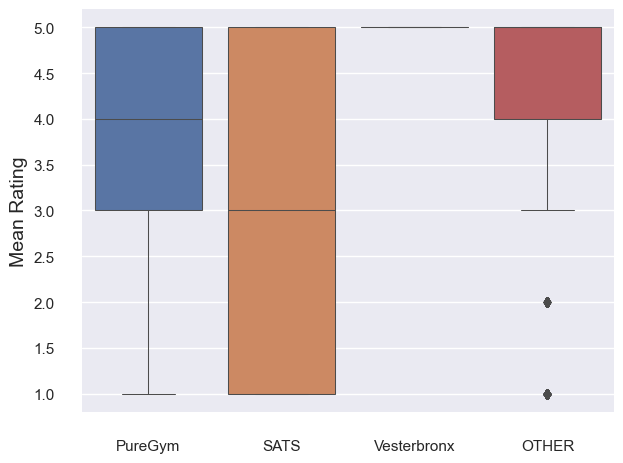

In [108]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set(font="Arial")

fig, ax = plt.subplots(1, 1)
sns.boxplot(ratings, palette="deep", color=".8", linewidth=.75)
ax.set_xticklabels(labels,fontsize=14) 
ax.set_ylabel("Mean Rating",fontsize=14) 

sns.despine(offset=10, trim=True)
fig.tight_layout()
plt.show()

In [35]:
from scipy.stats import f_oneway
f_oneway(reviews.loc[reviews.enterprise == "OTHER", "rating"], reviews.loc[reviews.enterprise == "PureGym", "rating"], reviews.loc[reviews.enterprise == "SATS", "rating"], reviews.loc[reviews.enterprise == "Vesterbronx", "rating"])


F_onewayResult(statistic=206.774207947859, pvalue=1.981236527098239e-126)

In [113]:
res = tukey_hsd(*ratings)
print(res)



Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.719     0.000     0.584     0.853
 (0 - 2)     -1.290     0.001    -2.157    -0.423
 (0 - 3)     -0.587     0.000    -0.718    -0.457
 (1 - 0)     -0.719     0.000    -0.853    -0.584
 (1 - 2)     -2.009     0.000    -2.876    -1.141
 (1 - 3)     -1.306     0.000    -1.443    -1.170
 (2 - 0)      1.290     0.001     0.423     2.157
 (2 - 1)      2.009     0.000     1.141     2.876
 (2 - 3)      0.703     0.159    -0.164     1.569
 (3 - 0)      0.587     0.000     0.457     0.718
 (3 - 1)      1.306     0.000     1.170     1.443
 (3 - 2)     -0.703     0.159    -1.569     0.164

